In [1]:
##########################
studies = [
    { 'study_name' : 'ac2', 'study_time' : 1200 },
    #{ 'study_name' : 'ac2', 'study_time' : 900 },
    { 'study_name' : 'chi19s2', 'study_time' : 900 },
    { 'study_name' : 'chi19s3', 'study_time' : 1500 }
    #{ 'study_name' : 'chi19s3', 'study_time' : 900 }
]
min_idea_submits = 3

# Must not be smaller than sliding_window
bucket_length = 60

# Sliding window defaults to bucket_length if <0
sliding_window = 10



In [2]:
##########################

import pandas as pd
import statistics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def filter_by_idea_submits(study_name, timer_value, min_idea_submits):
    data = pd.read_csv(study_name + '.csv', sep=';')
    column_name = str(timer_value) + '-ideaSubmitTimers'
    return data[data[column_name] >= min_idea_submits]

def get_median_requests(data, timer_value):
    column_name = str(timer_value) + '-inspirationRequestTimers'
    return statistics.median(data[column_name])   



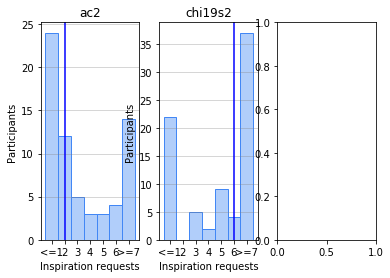

In [3]:
##########################
def print_histogram(study):
    filtered_data = filter_by_idea_submits(study['study_name'], study['study_time'], min_idea_submits)
    med = get_median_requests(filtered_data, study['study_time'])
    
    clipped_data = np.clip(filtered_data[str(study['study_time']) + '-inspirationRequestTimers'], 1, 7)
    plt.hist(clipped_data, bins=np.arange(8)+0.5, color = "#b1cefa", edgecolor='#4287f5')
    xticks =  np.insert(np.append(np.arange(2, 7), ">=7"),0, "<=1" )
    plt.title(study['study_name'])
    plt.xlabel('Inspiration requests')
    plt.ylabel('Participants')
    plt.xticks(np.arange(7) + 1, labels = xticks)
    plt.axvline(med, color = "blue")
    plt.grid(axis='y', alpha = 0.4, color = "gray")

fig = plt.figure()
fig.add_subplot(1,3,1)
print_histogram(studies[0])
fig.add_subplot(1,3,2)
print_histogram(studies[1])
fig.add_subplot(1,3,3)
#print_histogram(studies[2])
plt.show()

In [4]:
##########################

def get_types(filtered_data, timer_value):
    median = get_median_requests(filtered_data, timer_value)
    column_name = str(timer_value) + '-inspirationRequestTimers'
    seekers = filtered_data[filtered_data[column_name] > median]["workerId"]
    avoiders = filtered_data[filtered_data[column_name] <= 2]["workerId"]
    return {'seekers': seekers, 'avoiders': avoiders}
    

In [5]:
##########################

#seekers.size

# Get sliding-window buckets for each event array:
# Different lengths -> Fill up with zeros? Cut at smallest?
# Worker1: [[0,1,2,3],[1,2,3,4],[2,3,4,5],...]
#            ^^^^^^^^ one bucket

# in seconds




In [6]:
def get_events_per_type(study, types):
    submits = pd.read_csv(study['study_name'] + '_ideaSubmits.csv', sep=';')
    requests = pd.read_csv(study['study_name'] + '_inspirationRequests.csv', sep=';')
    return {
        'avoiders': [
            submits[submits['workerId'].isin(types['avoiders'])],
            requests[requests['workerId'].isin(types['avoiders'])]
        ],
        'seekers': [
            submits[submits['workerId'].isin(types['seekers'])],
            requests[requests['workerId'].isin(types['seekers'])]
        ]
    }

def get_event_data(submits_table, requests_table):        
    submits_table = submits_table.drop(columns = "workerId")
    requests_table = requests_table.drop(columns = "workerId")
    event_data = []
    for i in range(len(submits_table)):
        event_data.append(create_bucket(submits_table.iloc[i,:], requests_table.iloc[i,:]))
    return event_data

def create_bucket(submitsRow, requestsRow):
    results = []
    i = 0
    #print(submitsRow.shape)
    #print(requestsRow.shape)
    while i < submitsRow.size:
        result = sum(submitsRow[i:i+bucket_length])
        results.append(result)
        i+=bucket_length
    i = 0
    while i < requestsRow.size:
        result = sum(requestsRow[i:i+bucket_length])
        results.append(result)
        i+=bucket_length
    return results

def get_result(events_per_type): 
    # input {'avoiders': [[submits x seconds: 0, 0, 0, 1, 1, 0], [requests x seconds: 0, 0, 0, 1, 1, 0]], ...}
    # output {'avoiders': [submits x bucket_length: 0, 4, 2], [requests x bucket_length: 0, 2, 0]}
    avoiders = get_event_data(events_per_type['avoiders'][0], events_per_type['avoiders'][1])
    seekers = get_event_data(events_per_type['seekers'][0], events_per_type['seekers'][1])
    return {
        'avoiders': avoiders,
        'seekers': seekers
    }


def get_results_for_all_studies(): 
    results = {}
    for study in studies:
        filtered_data = filter_by_idea_submits(study['study_name'], study['study_time'], min_idea_submits)
        # TODO: fill data up with 0s
        
        types = get_types(filtered_data, study['study_time'])
        
        # {'avoiders': [[submits], [requests], ], ...}
        events_per_type = get_events_per_type(study, types)
        
        result = get_result(events_per_type)
        results[study['study_name']] = result
    return results
    

In [7]:
all_studies = get_results_for_all_studies()
# determine matrix size
# nr of buckets = max number of buckets
max_bucket_size = 0
for study_name in all_studies.keys():
    max_bucket_size = max(max_bucket_size, len(all_studies[study_name]['avoiders'][0]))
# nr of lines = sum of lines
nr_lines = sum([len(all_studies[study_name][name]) for study_name in all_studies.keys() for name in ['avoiders', 'seekers']])
x, y = np.zeros((nr_lines, max_bucket_size)), np.zeros(nr_lines)
current_line = 0
for study_name in all_studies.keys():
    for y_value, type in enumerate(['avoiders', 'seekers']):
        type_results = np.array(all_studies[study_name][type])
        type_count = len(type_results)
        bucket_count = len(type_results[0])
        x[current_line:current_line+type_count,:bucket_count] += type_results
        y[current_line:current_line+type_count] = y_value 
        current_line += type_count
        
def shorten_x(x, perc=0.5):
    nrows, ncols = x.shape
    # take x features apart by bins of submits and requests
    col_cut = int(ncols/2)
    x_submits, x_requests = x[:,:col_cut], x[:,col_cut:]
    # create return array
    cut_partial = int(perc*int(ncols/2))
    x_return = np.zeros((nrows, 2*cut_partial))
    x_return[:,:cut_partial] = x_submits[:,:cut_partial]
    x_return[:,cut_partial:] = x_requests[:,:cut_partial]
    return x_return

x_train, x_test, y_train, y_test = train_test_split(shorten_x(x, 0.4), y, test_size=0.25)
print(x.shape, y.shape)
print(x_train.shape, y_test.shape)

(150, 50) (150,)
(112, 20) (38,)


In [8]:
# trees offer readable rules
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# support vector machines (svm) allow for simple (but effective) classification
from sklearn.svm import SVC

# metric by which to measure the ml algorithm
from sklearn.metrics import confusion_matrix

# instantiate classifier
#clf = DecisionTreeClassifier(max_depth=10)
#clf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
clf = SVC(kernel='linear')

# train classifier
clf.fit(x_train, y_train)
#clf.fit(list(x_train)+list(x_test), list(y_train)+list(y_test))

print(x_test)
# get predicted classes
y_pred = clf.predict(x_test)
print(y_pred)
print('confusion matrix:\n', confusion_matrix(y_pred, y_test))

[[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 4. 3. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 1. 2. 1. 2. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 2. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 2. 0. 1. 1. 0. 0. 0.